 This notebook continues from **Notebook 8**, where we applied bandpass filtering to seismic signals. Now, I would leverage those clean signals to detect real seismic events using the STA/LTA algorithm.
## Real Event Detection using STA/LTA (Short-Term Average / Long-Term Average)
**STA/LTA are especially for local earthquake detection in real-time monitoring systems.**  
This notebook focuses on detecting seismic events using the STA/LTA algorithm, a common trigger method in seismology. I will:
- Download real waveform data from IRIS
- Apply a bandpass filter to remove noise
- Calculate STA/LTA characteristic function
- Detect event onsets
- Visualize detected events


In this notebook, I am working on detecting seismic events using the STA/LTA (Short-Term Average/Long-Term Average) method. This is a commonly used technique in seismology to identify seismic events based on changes in amplitude over short and long periods. The seismic data is sourced from the IRIS network, specifically from the ANMO station, which is known for significant earthquake activity.

I’ll start by fetching a short segment of real seismic data just before a known earthquake, apply preprocessing steps like detrending and filtering, and then use the STA/LTA method to detect any seismic events. The goal is to analyze this data, visualize the results, and understand how seismic events are identified using this method.

**Fetching seismic data (10 minute)**

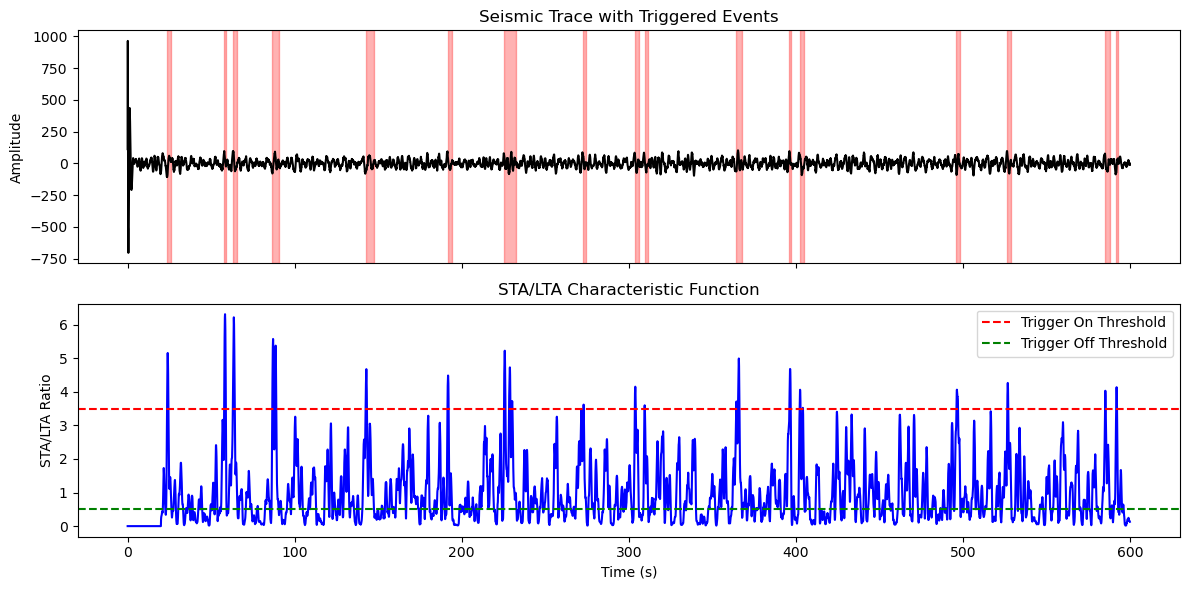

In [1]:
from obspy import read, UTCDateTime
from obspy.clients.fdsn import Client
from obspy.signal.trigger import classic_sta_lta, trigger_onset
import matplotlib.pyplot as plt
import numpy as np

# Connect to IRIS and get a short waveform segment from a real earthquake
client = Client("IRIS")

starttime = UTCDateTime("2010-02-27T06:30:00")  # Just before a known large event
endtime = starttime + 10 * 60  # 10 minutes of data

st = client.get_waveforms(network="IU", station="ANMO", location="00", channel="BHZ",
                          starttime=starttime, endtime=endtime)
st.detrend("linear")
st.filter("bandpass", freqmin=0.5, freqmax=5.0)

tr = st[0]  # Single trace

# Parameters for STA/LTA
nsta = int(1 * tr.stats.sampling_rate)   # 1 second window
nlta = int(20 * tr.stats.sampling_rate)  # 20 second window

# Computing characteristic functions
cft = classic_sta_lta(tr.data, nsta, nlta)

# Trigger detection thresholds
on_thresh = 3.5
off_thresh = 0.5
trig_onsets = trigger_onset(cft, on_thresh, off_thresh)

# Plot the waveform and detected triggers
fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Plot waveform
ax[0].plot(tr.times(), tr.data, 'k')
for onset in trig_onsets:
    ax[0].axvspan(tr.times()[onset[0]], tr.times()[onset[1]], color='red', alpha=0.3)
ax[0].set_title("Seismic Trace with Triggered Events")
ax[0].set_ylabel("Amplitude")

# Plot STA/LTA characteristic function
ax[1].plot(tr.times(), cft, 'b')
ax[1].axhline(on_thresh, color='r', linestyle='--', label="Trigger On Threshold")
ax[1].axhline(off_thresh, color='g', linestyle='--', label="Trigger Off Threshold")
ax[1].set_title("STA/LTA Characteristic Function")
ax[1].set_ylabel("STA/LTA Ratio")
ax[1].set_xlabel("Time (s)")
ax[1].legend()

plt.tight_layout()
plt.show()
